**<h3><center>EN2550  Exercise 8</center></h3>**
*Name - Ekanayake E.M.S.S.N.*
<br>
*Index no - 190164M*
<hr>

In [6]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

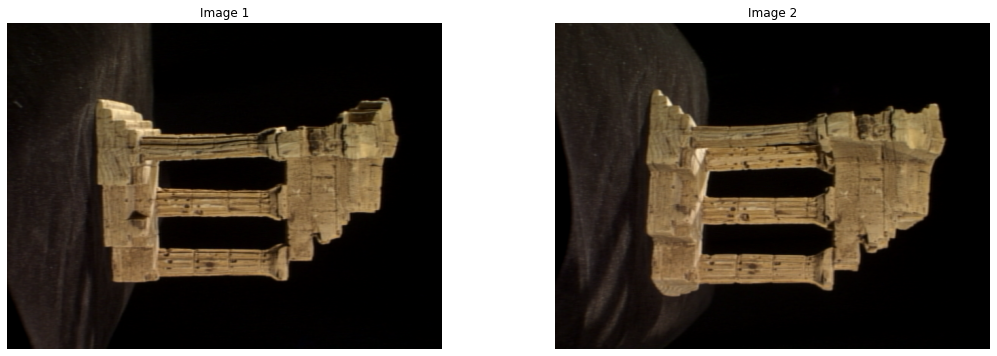

In [35]:
#Q01
f = open(r'Images/templeSparseRing/templeSR_par.txt', 'r')
assert f is not None
n = int(f.readline())

#image 1
l = f.readline().split()
im1_fn = l[0]
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

#image 2
l = f.readline().split()
im2_fn = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

#read the images and show
im1 = cv.imread(r'Images/templeSparseRing/' + im1_fn, cv.IMREAD_COLOR)
im2 = cv.imread(r'Images/templeSparseRing/' + im2_fn, cv.IMREAD_COLOR)
assert im1 is not None
assert im2 is not None

fig , ax =  plt.subplots(1,2,figsize=(18,6))
ax[0].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax[0].set_title('Image 1')
ax[0].axis('off')

ax[1].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
ax[1].set_title('Image 2')
ax[1].axis('off')

# Compute P1 and P2
P1 = K1 @ np.hstack((R1,t1))  # P = K*[R|t]
P2 = K2 @ np.hstack((R2,t2))  # P = K*[R|t]


In [36]:
from scipy.linalg import null_space 

def skew(x):
    x = x.ravel()
    return np.array ([[0, -x[2], x[1]],[x[2], 0, -x[0]], [-x[1], x[0],0]])

C = null_space(P1) 
C = C * np.sign(C[0,0])

e2 = P2 @ C

e2x = skew(e2)

F = e2x @ P2 @ np.linalg.pinv(P1)
print(F)

[[-2.87071497e-04 -3.96261289e-02  2.94221686e+02]
 [-3.55039713e-02  1.65329260e-04  1.78860854e+01]
 [-2.76702814e+02  2.12942175e+01 -9.06669374e+03]]


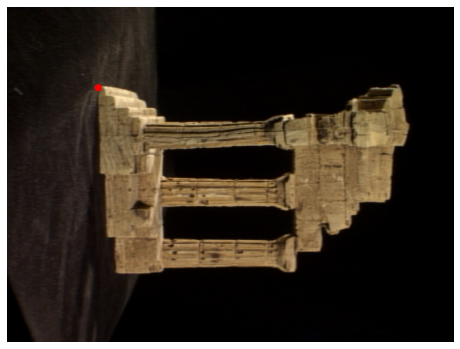

In [37]:
#Q02
x = np.array([130, 115,1])

cv.circle(im1 , (x[0], x[1]), 5 , (0,0,255),-1)
fig , ax =  plt.subplots(figsize = (8,8))
ax.imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

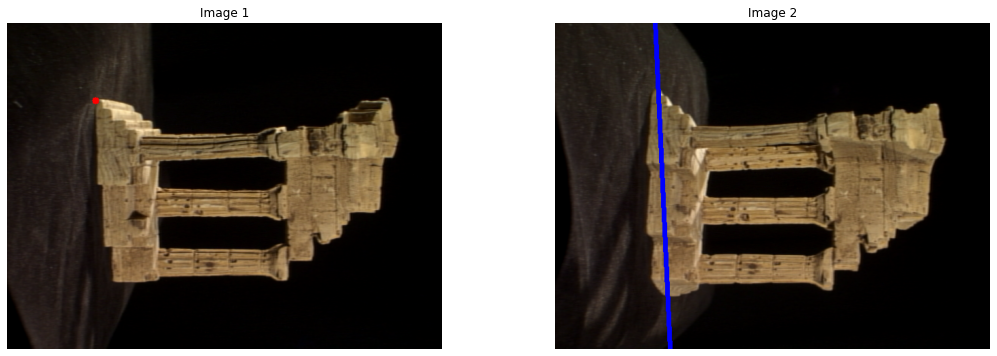

In [39]:
#Q03
l2 = F @ x.T
p1 = np.array([0, (l2[0]*0 + l2[2])/l2[1]]).astype(int)
p2 = np.array([500, (l2[0]*500 + l2[2])/l2[1]]).astype(int)

cv.line(im2, (p1[0],p1[1]),(p2[0], p2[1]),(255,0,0),5)
img1=cv.cvtColor(im1, cv.COLOR_BGR2RGB)
img2=cv.cvtColor(im2, cv.COLOR_BGR2RGB)

fig , ax =  plt.subplots(1,2,figsize=(18,6))
ax[0].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax[0].set_title('Image 1')
ax[0].axis('off')

ax[1].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
ax[1].set_title('Image 2')
ax[1].axis('off')

plt.show()

In [40]:
#Q04

sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

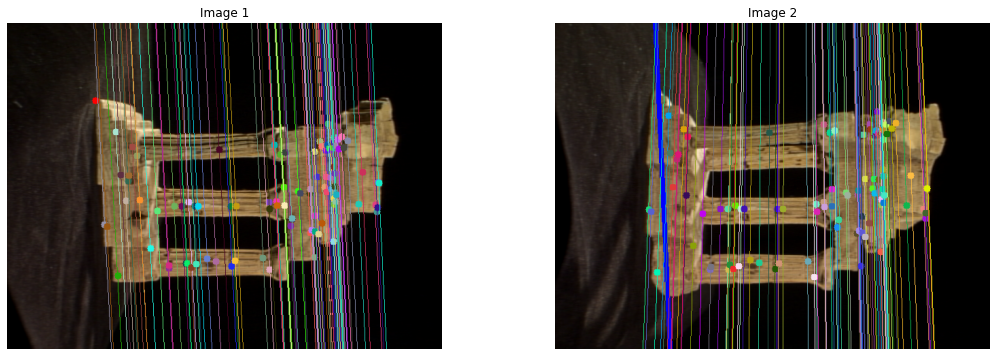

In [46]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

def drawlines(img1,img2,lines,pts1,pts2):
    r,c =img1.shape[0],img1.shape[1]
    img1 = cv.cvtColor(img1,cv.COLOR_RGB2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_RGB2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2


lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

fig , ax =  plt.subplots(1,2,figsize=(18,6))
ax[0].imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title('Image 1')

ax[1].imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
ax[1].axis('off')
ax[1].set_title('Image 2')

plt.show()